## Boston Housing Dataset

In [1]:
from keras.datasets import boston_housing

/Users/duarteocarmo/anaconda/envs/DeepLearning/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/duarteocarmo/anaconda/envs/DeepLearning/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets[0:5]

array([15.2, 42.3, 50. , 21.1, 17.7])

## Preparing the data

In [6]:
# normalization 
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# check this! Even for normalization, we use training data
test_data -= mean
test_data /= std

## Building Network

In [7]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop' ,loss='mse', metrics=['mae'])
    return model

## Validating the approach using K-Fold validation

In [11]:
import numpy as np

k = 4
num_val_samples = len(train_data) // 4
num_epochs = 100
all_scores = []

for i in range(k):
    print('Processing fold #{}..'.format(i))
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                         train_data[(i + 1) * num_val_samples:]], 
                                         axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                         train_targets[(i + 1) * num_val_samples:]], 
                                         axis=0)
    
    model = build_model()
    
    model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets), 
              epochs=num_epochs, 
              batch_size=1, 
              verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0..
Processing fold #1..
Processing fold #2..
Processing fold #3..


In [12]:
# print validation scores
print(all_scores)

[1.992454243178415, 2.238586716132589, 2.851489520308995, 2.399850637605875]


In [13]:
print(np.mean(all_scores))

2.3705952793064684


In [14]:
# now using 500 epochs
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('Processing fold #{}..'.format(i))
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], 
                                         train_data[(i + 1) * num_val_samples:]], 
                                         axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                         train_targets[(i + 1) * num_val_samples:]], 
                                         axis=0)
    
    model = build_model()
    
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets), 
                        epochs=num_epochs, 
                        batch_size=1, 
                        verbose=0)
    
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

Processing fold #0..
Processing fold #1..
Processing fold #2..
Processing fold #3..


In [15]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

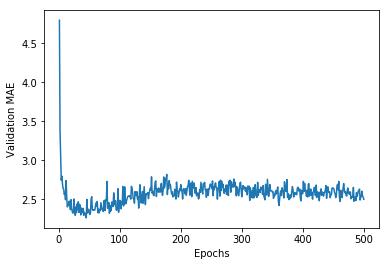

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

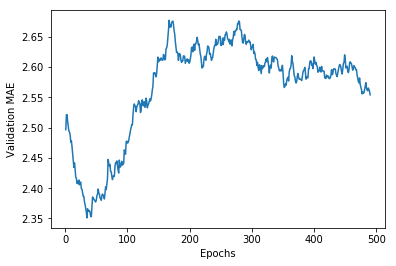

In [21]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [24]:
ideal_epochs = np.argmin(smooth_mae_history)
print('The ideal number of epochs is {}.'.format(ideal_epochs))
# final model
model = build_model()
model.fit(train_data, train_targets,
          epochs=ideal_epochs, batch_size=16, 
          verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

The ideal number of epochs is 34.
102/102 [==============================] - 0s 794us/step


In [28]:
print('We are of by ${} on average'.format(str(round(test_mae_score, 2) * 1000)))

We are of by $3090.0 on average


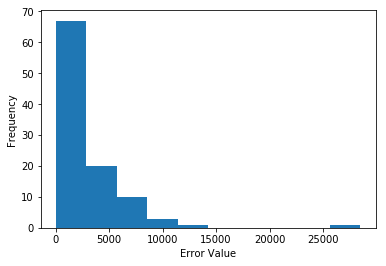

In [58]:
plt.clf()
plt.hist(abs(test_targets - predictions.flatten()) * 1000, bins=10)
plt.xlabel('Error Value')
plt.ylabel('Frequency')
plt.show()